In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import ROOT
from ROOT import TH1F, TF1, TCanvas
import uproot
import iminuit
import probfit
%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
def smooth(x, window_len=11, window="hanning"):
    # if x.ndim != 1:
    #     raise ValueError("smooth only accepts 1 dimension arrays.")

    # if x.size < window_len:
    #     raise ValueError("Input vector needs to be bigger than window size.")

    # if window_len < 3:
    #     return x

    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]
    # print(len(s))
    if window == "flat":  # moving average
        w = np.ones(window_len)
    else:
        w = eval("np." + window + "(window_len)")

    y = signal.convolve(s, w / w.sum(), mode="same")

    return y

In [3]:
!ls

muon_decay-Copy1.ipynb	root_converter.ipynb
muon_decay.ipynb	single_analysis_test.ipynb


In [4]:
# rel_path = "./Labs/muon_decay/"
# filename = rel_path + "oscil_191216.root"
rel_path = "../../Labs/"
filename = rel_path + "mudecays824.root"

In [5]:
# df = RDataFrame("tree",filename)

In [6]:
# df_np = RDataFrame("tree",filename).AsNumpy()
# df_np["channel1"].size

In [7]:
# raw_data = df_np["channel1"][1169]
# n_per_event = raw_data.size()
# timesteps = np.arange(0,n_per_event,1)
# raw_data *= -1.0

In [8]:
df_np = uproot.open(filename)["t1"].array("channel1")
n_events = df_np.size
n_per_event = df_np[0].size
timesteps = np.arange(0,n_per_event,1)


In [9]:
raw_data = np.negative(df_np[37])

In [10]:
smoothed_data = smooth(raw_data, window_len=51, window='bartlett')
data = np.concatenate((timesteps[:,np.newaxis], smoothed_data[:n_per_event ,np.newaxis]), axis=1)
peak_range = [0.1, data[: ,1].max() ]
peaks, properties = signal.find_peaks(data[: ,1], height=peak_range,distance=250)
results_w = signal.peak_widths(data[: ,1], peaks, rel_height=0.95)


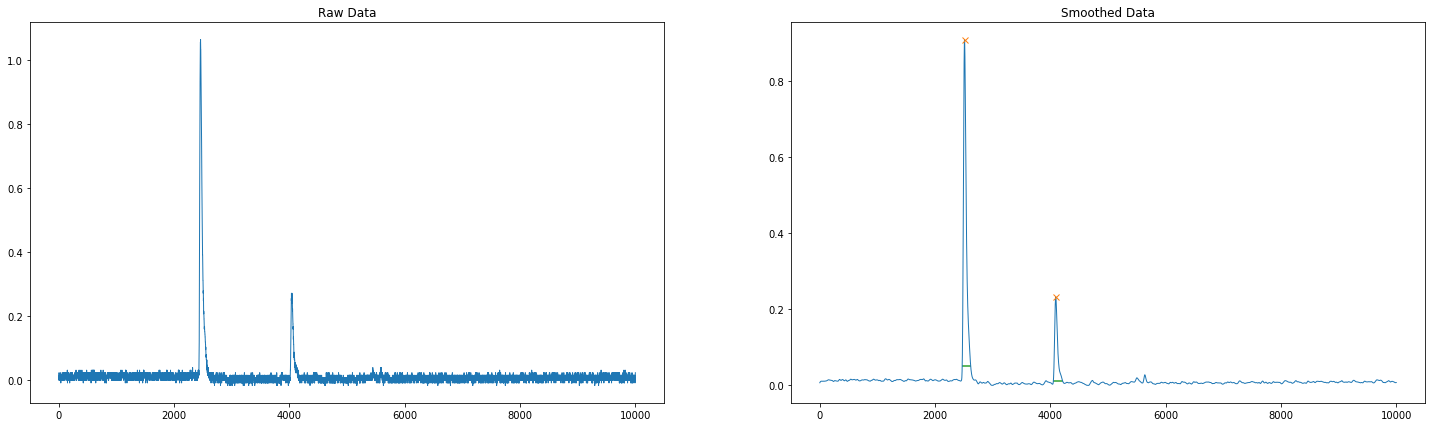

In [11]:
plt.figure(figsize=(25,7))
plt.subplot(121)
plt.plot(timesteps, raw_data, '-', lw=1)
plt.title("Raw Data")
plt.subplot(122)
plt.plot(data[:,0], data[:,1],'-', lw=1)
plt.plot(peaks, data[:,1][peaks], "x")
plt.hlines(*results_w[1:], color="C2")
plt.title("Smoothed Data")
plt.show()

In [12]:
print(f'Peaks width: {results_w[0]}')
for i in range(results_w[1:][0].size):
    print(f'Found peak in range: {results_w[2][i]}, {results_w[3][i]}')
print(f"Found peaks at indices {peaks} with amplitude: {data[peaks,0]}")

Peaks width: [146.39827387 159.8947696 ]
Found peak in range: 2470.105778379259, 2616.504052247739
Found peak in range: 4051.351901622807, 4211.246671227415
Found peaks at indices [2510 4093] with amplitude: [2510. 4093.]


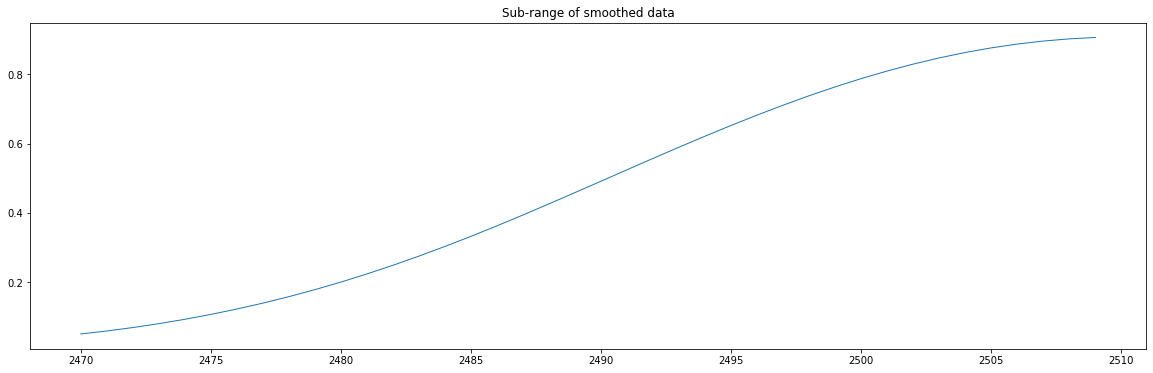

In [13]:
a = int(min(results_w[2]))
ranged_sm_data = data[a:peaks[0]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,0], ranged_sm_data[:,1],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

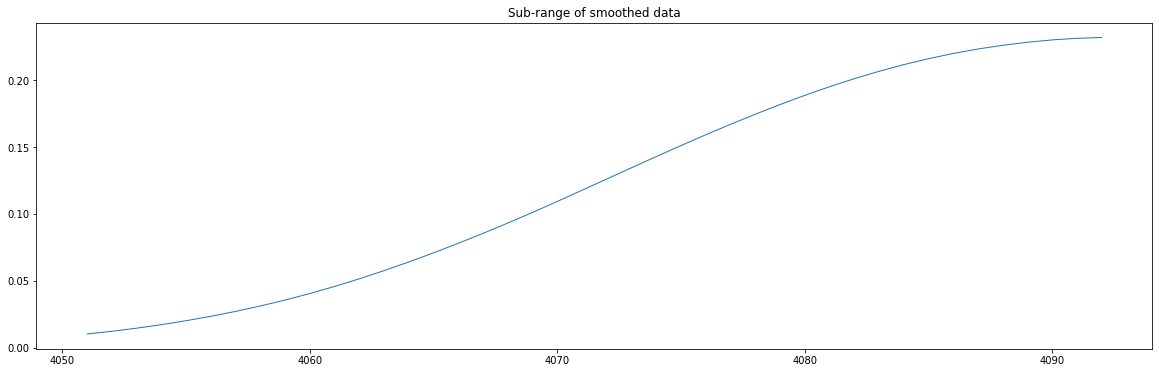

In [14]:
b = int((results_w[2][1]))
# print(b,peaks[1])
ranged_sm_data = data[b:peaks[1]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,0], ranged_sm_data[:,1],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

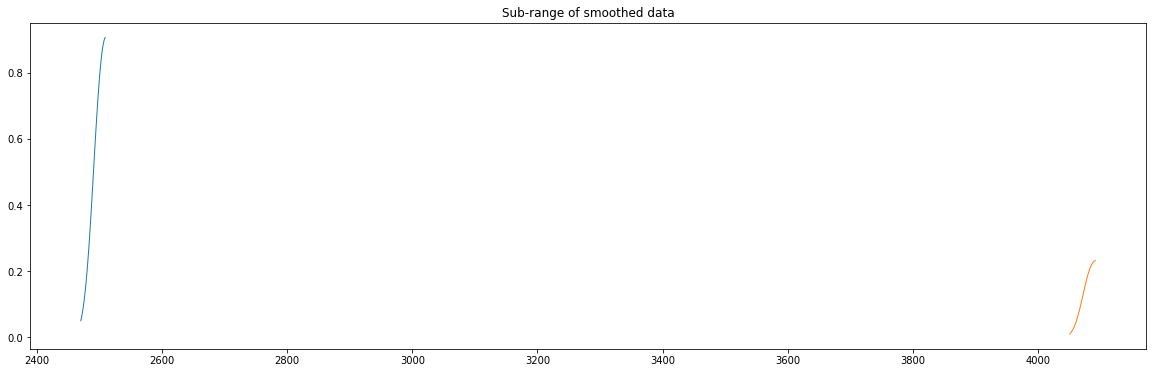

In [15]:
plt.figure(figsize=(20,6))
for min_t, peak in zip(results_w[2], peaks):
    min_t = int(min_t)
    ranged_sm_data = data[min_t:peak]
    plt.plot(ranged_sm_data[:,0], ranged_sm_data[:,1],'-', lw=1)
    plt.title("Sub-range of smoothed data")
plt.show()

In [16]:
# We want to speed things up with Cython
%load_ext Cython

In [17]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def sigmoid(double x, double p0, double p1, double p2, double p3):
    return p0 / (1.0 + exp(-1.0 * p2 * (x - p1) ) ) + p3


# def sigmoid(x, p0, p1, p2, p3):
#     return p0 / (1.0 + np.exp(-1.0 * p2 * (x - p1))) + p3


In [18]:
iminuit.describe(sigmoid)

['x', 'p0', 'p1', 'p2', 'p3']

In [19]:
chi2_fit = probfit.Chi2Regression(
    sigmoid,
    data[a : peaks[0], 0],
    data[a : peaks[0], 1],
)

minuit = iminuit.Minuit(
                chi2_fit,
                p0=np.max(data[a : peaks[0] + 1, 1]),
                p1=peaks[0],
                p3=np.min(data[a : peaks[0] + 1, 1]),
#                 limit_p3=(np.min(data[a : peaks[0], 1]), None),
                pedantic=False,
                print_level=1,
            )
minuit.migrad()
try:
    minuit.hesse()
except Exception as e:
    print(str(e))

------------------------------------------------------------------
| FCN = 0.0004532               |     Ncalls=571 (571 total)     |
| EDM = 9.62E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

In [20]:
# iminuit.describe(chi2_fit)

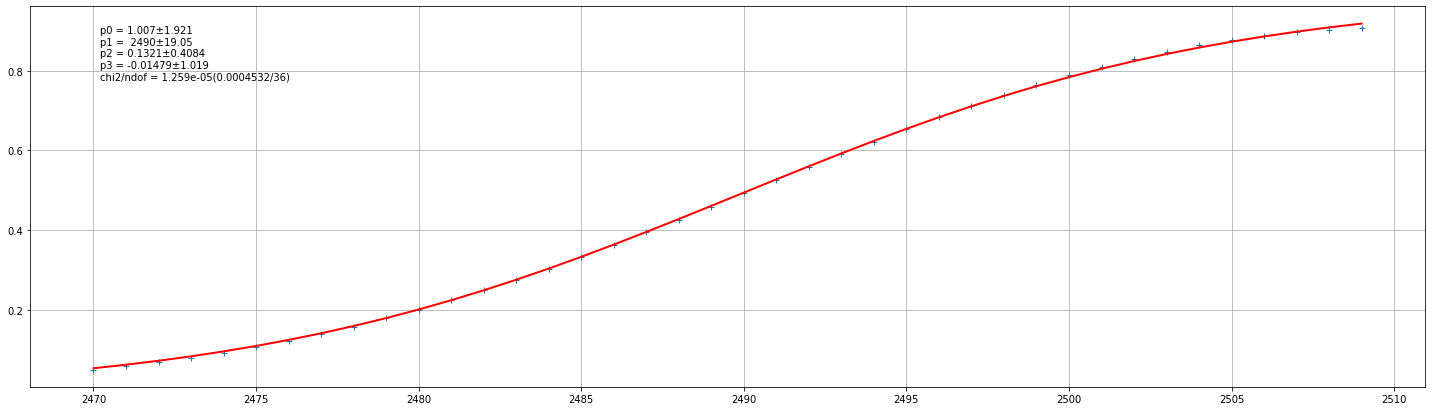

In [21]:
plt.figure(figsize=(25, 7))
chi2_fit.draw(minuit)
plt.show()

In [22]:
# minuit.print_fmin()
# minuit.print_matrix()

In [23]:
print(minuit.values)
print(minuit.errors)

<ValueView of Minuit at 557e1bbe12e0>
  p0: 1.0069473277028653
  p1: 2489.839782276113
  p2: 0.13213880224966792
  p3: -0.014790503765125442
<ErrorView of Minuit at 557e1bbe12e0>
  p0: 1.9212883333294217
  p1: 19.047748900206912
  p2: 0.40836200594343486
  p3: 1.0194311440022308


In [24]:
print(f'The value of the variable p0 is {minuit.values["p0"]}') 
print(f'The value of the variable p1 is {minuit.values["p1"]}') 
print(f'The value of the variable p2 is {minuit.values["p2"]}') 
print(f'The value of the variable p3 is {minuit.values["p3"]}') 

The value of the variable p0 is 1.0069473277028653
The value of the variable p1 is 2489.839782276113
The value of the variable p2 is 0.13213880224966792
The value of the variable p3 is -0.014790503765125442


## Fitting second peak

------------------------------------------------------------------
| FCN = 0.0001417               |     Ncalls=160 (160 total)     |
| EDM = 0.000102 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

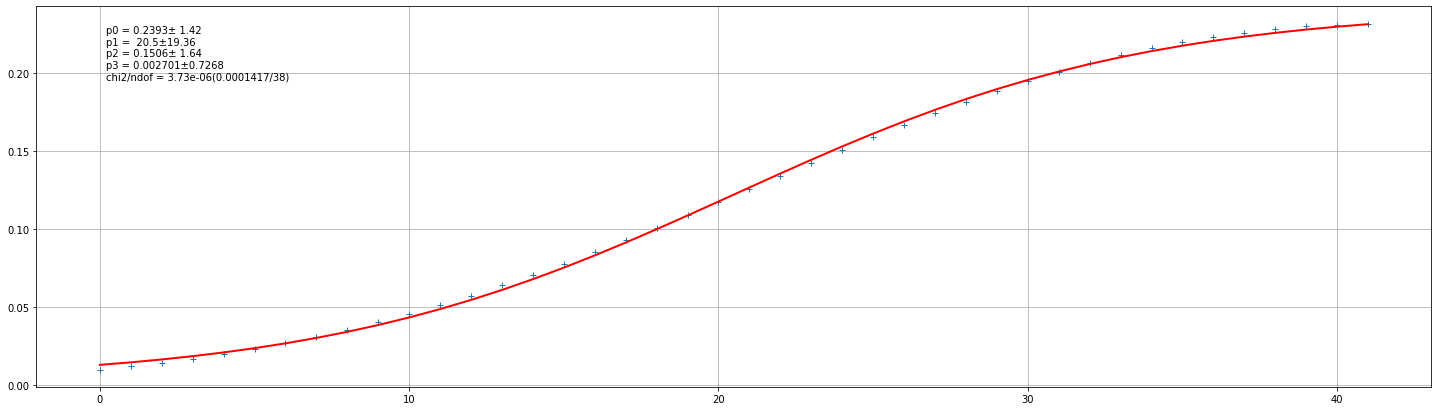

['x', 'p0', 'p1', 'p2', 'p3']

In [61]:
t2 = np.arange(0, data[b : peaks[1], 0].size)
chi2_fit_p2 = probfit.Chi2Regression(
    sigmoid,
#     data[b : peaks[1], 0],
    t2,
    data[b : peaks[1], 1],
)

minuit_p2 = iminuit.Minuit(
                chi2_fit_p2,
#                 p0=np.max(data[b : peaks[1], 1]),
#                 p1=peaks[1],
                limit_p1=(t2.max()/2, t2.max()),
#                 p3=np.min(data[b : peaks[1], 1]),
#                 limit_p3=(np.min(data[b : peaks[1], 1]), None),
#                 fix_p3=np.min(data[b : peaks[1], 1]),
                pedantic=False,
                print_level=1,
            )

minuit_p2.migrad()
try:
    minuit_p2.hesse()
except Exception as e:
    print(str(e))

plt.figure(figsize=(25, 7))
chi2_fit_p2.draw(minuit_p2)
plt.show()
iminuit.describe(sigmoid)

In [26]:
np.min(data[b : peaks[1], 1])

0.010175998112900035

In [50]:
print(f'The value of the variable p0 is {minuit_p2.values["p0"]}') 
print(f'The value of the variable p1 is {minuit_p2.values["p1"]}') 
print(f'The value of the variable p2 is {minuit_p2.values["p2"]}') 
print(f'The value of the variable p3 is {minuit_p2.values["p3"]}') 

The value of the variable p0 is 0.7465111768095255
The value of the variable p1 is 4072.107476454357
The value of the variable p2 is 0.03520498117282995
The value of the variable p3 is -0.24674622417862233


In [28]:
p = minuit_p2.values
p[1] - np.log(p[0] / (0.2 * data[b : peaks[1], 1].max() - p[3]) - 1) / p[2]

4061.224931207861

## Trying ROOT fitting because iminuit doesnt like that data

In [29]:

sg = """
Double_t sig_cpp(Double_t *x, Double_t *par)
{
  return par[0] / (1.0 + TMath::Exp(-par[2] * (x[0] - par[1]))) + par[3];
};
"""
ROOT.gInterpreter.Declare(sg)

True

 FCN=0.000186217 FROM MIGRAD    STATUS=CONVERGED     683 CALLS         684 TOTAL
                     EDM=2.7808e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.57835e-01   5.24781e-01   5.28190e-05  -1.15197e-03
   2  p1           2.10430e+01   2.45556e+01   3.76469e-03   4.59560e-06
   3  p2           1.31797e-01   4.41465e-01   4.80904e-05  -1.74891e-03
   4  p3          -5.98324e-03   1.90778e-01   1.74186e-05   1.27273e-03


Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).


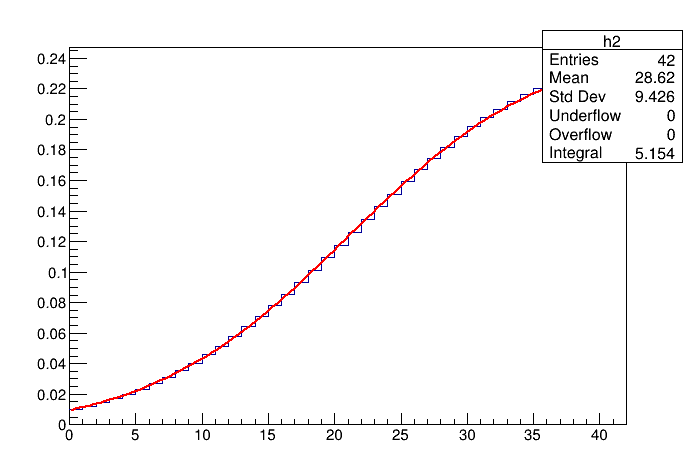

In [72]:
ROOT.gStyle.SetOptStat(1111111)
c1 = TCanvas()
hist_p2 = TH1F("h2"," ", data[b : peaks[1], 0].size, 0, data[b : peaks[1], 0].size)
for i, vt in enumerate(data[b : peaks[1], 1]):
    hist_p2.SetBinContent(hist_p2.GetBin(i + 1), vt)
#     print(i, vt)

g2 = TF1("g2", ROOT.sig_cpp, 0, data[b : peaks[1], 0].size, 4)
g2.SetParameter(1, data[b : peaks[1], 0].size)
hist_p2.Fit(g2, "R")
hist_p2.Draw("same")
c1.Draw()

42

## whatever stuf

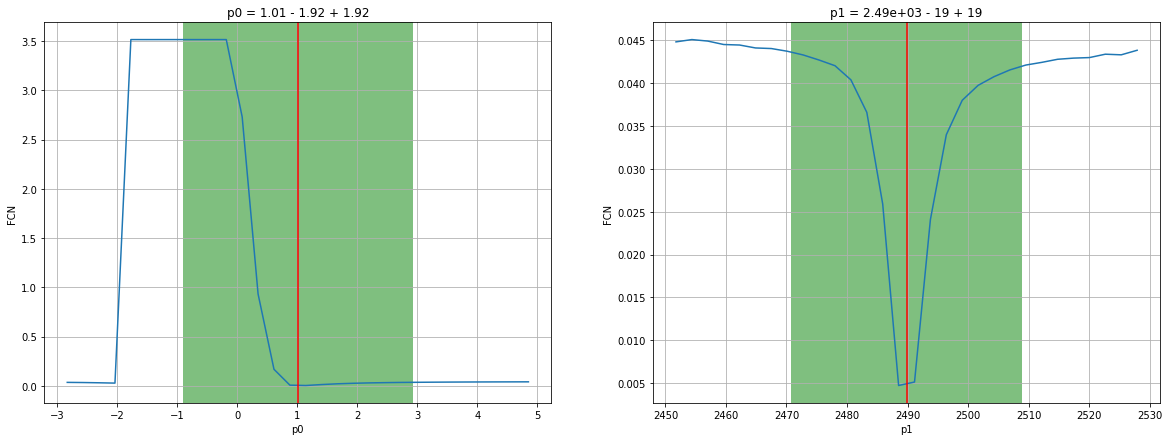

In [31]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p0')
plt.subplot(122)
minuit.draw_mnprofile('p1')
plt.show()

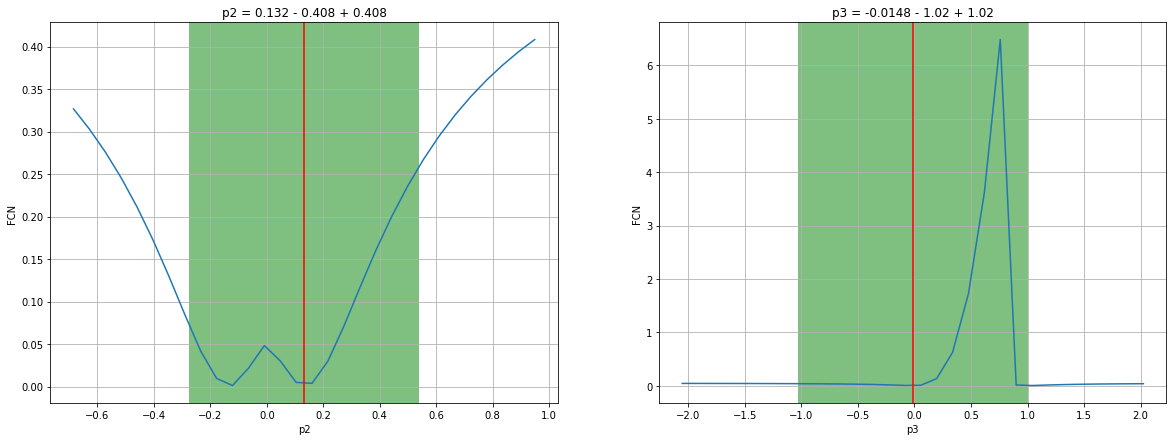

In [32]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p2')
plt.subplot(122)
minuit.draw_mnprofile('p3')
plt.show()

In [33]:
plt.rcParams['figure.figsize'] = (10, 7)


In [34]:
# intial parameters
n_iter = 10000
sz = (n_iter,) # size of array
x = 0# truth value (typo in example at top of p. 13 calls this z)
# z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)
z = raw_data

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor


In [35]:
# R = 0.1**2 # estimate of measurement variance, change to see effect
R = 0.01**2
# intial guesses
xhat[0] = 0.0
P[0] = 2

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

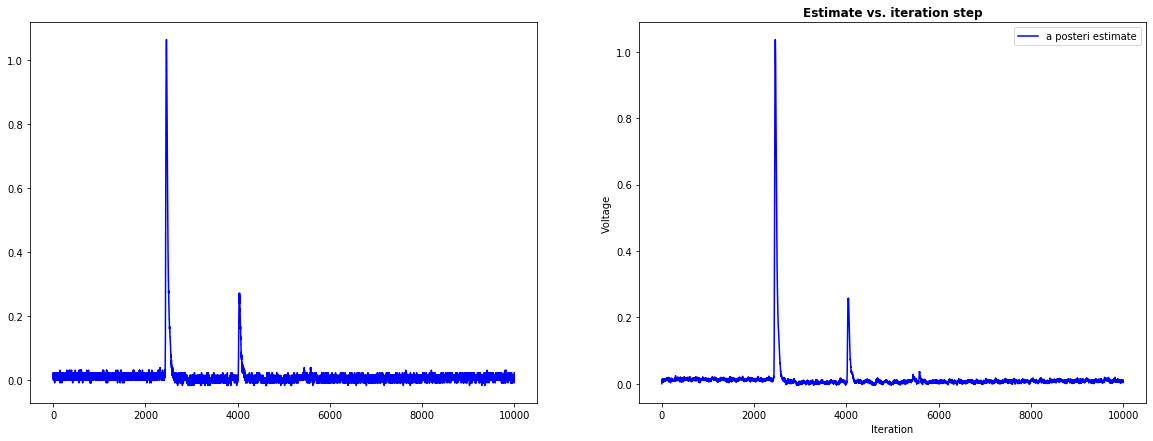

In [36]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(z,'b-',label='noisy measurements')
plt.subplot(122)
plt.plot(xhat,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')
plt.show()

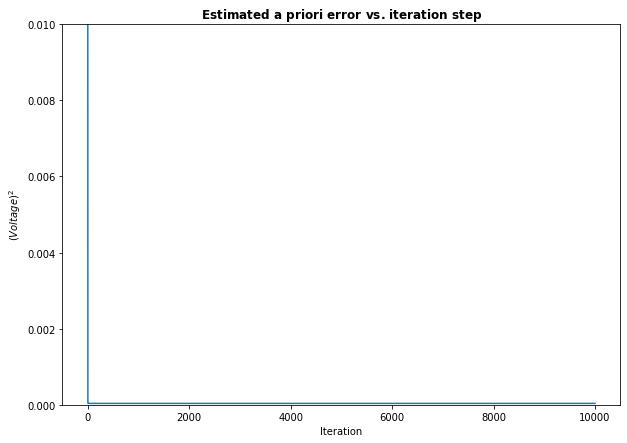

In [37]:
plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.setp(plt.gca(),'ylim',[0,.01])
plt.show()

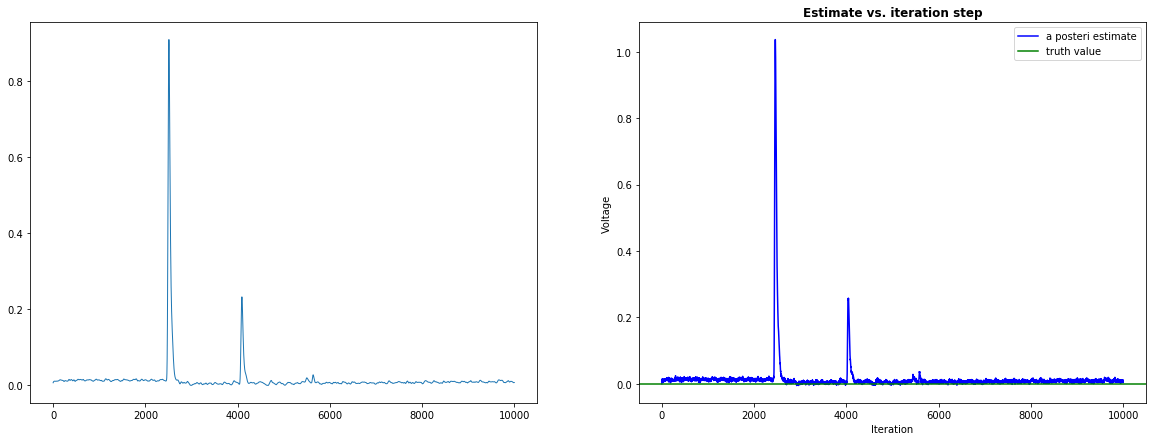

In [38]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(data[:,0], data[:,1],'-', lw=1)
plt.subplot(122)
plt.plot(xhat,'b-',label='a posteri estimate')
plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')
plt.show()

In [39]:
peaks_kl, _ = signal.find_peaks(xhat, height=[0.1,None],distance=250)
results_kl = signal.peak_widths(xhat, peaks_kl, rel_height=0.95)

In [40]:
print(f'Peaks width: {results_kl[0]}')
for i in range(results_kl[1:][0].size):
    print(f'Found peak in range: {results_kl[2][i]}, {results_kl[3][i]}')
print(f"Found peaks at indices {peaks_kl} with amplitude: {xhat[peaks_kl]}")

Peaks width: [135.55495438 145.41227258]
Found peak in range: 2432.562838162249, 2568.117792537763
Found peak in range: 4013.5056215264794, 4158.917894109321
Found peaks at indices [2459 4044] with amplitude: [1.03690013 0.25776481]


In [41]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../../')

In [42]:
from src.python.kalman import kalman

In [43]:
ayy = np.asarray(raw_data)

In [44]:
lmao = kalman.kalman_filter(ayy, len(ayy))

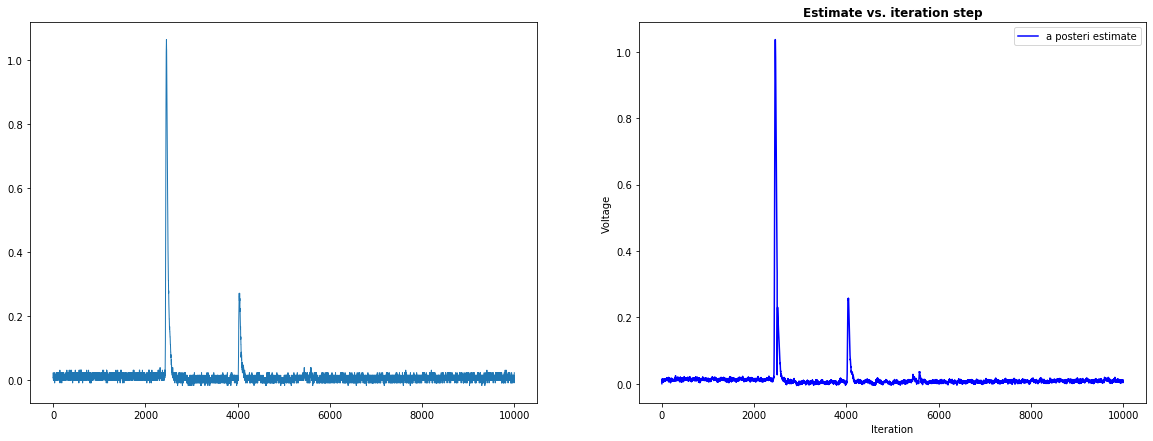

In [45]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(ayy,'-', lw=1)
plt.subplot(122)
plt.plot(lmao,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')
plt.show()